# Curve Fitting Uncertainties with PSL Uncertainty Calculator

This notebook demonstrates curve fitting, both linear and non-linear, using the curvefit module of the PSL uncertainty calculator. The model parameters (e.g. slope and intercept in the linear case) are fit using a least-squares regression. Uncertainties in the parameters are computed using four different methods for comparison. For a description of each method, see the `Curvefit Methods` notebook.

The `CurveFit` class takes `func` as an argument. This can be a callable Python function, a sympifyable string expression, or one of the predefined function names as follows:

- `line` - (default): $y = a + bx$
- `exp` - Exponential: $y = a exp{(x/b)} + c$
- `decay` - Exponential decay, no offset: $y = a \exp{(-x/b)}$
- `log` - Natural Log function: $y = a + b \log{(x-c)}$
- `logistic` - Logistic growth: $y = a / (1 + \exp{((x-c)/b)}) + d$
- `quad` - Quadratic Polynomial: $y = a + bx + cx^2$
- `cubic` - Cubic Polynomial: $y = a + bx + cx^2 + dx^3$
- `poly` - General Polynomial. Provide `polyorder` parameter: $y = a + bx + cx^2 ... kx^n$

Once the pamrater values and uncertainties are computed, functions for finding confidence band of the fit line and a prediction band for new measurements are also generated and plotted.

The fit values and uncertainties are found using the four methods described below for comparison.

#### Definitions:
Confidence band: Uncertainty that the fit line passes through the true mean value of the line

Prediction band: Uncertainty in taking a new measurement at a given X value.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import wofz  # For the Voigt function example

import suncal
from suncal import curvefit

In [2]:
def plotit(f):
    ''' Calculate and plot comparison of fits '''
    cols = 4 if f.mcmc else 3
    fig, ax = plt.subplots(ncols=cols, figsize=(14,4))
    f.gum.plot_summary(ax=ax[0])
    f.lsq.plot_summary(ax=ax[1])
    f.mc.plot_summary(ax=ax[2])
    if f.mcmc:
        f.mcmc.plot_summary(ax=ax[3])
        ax[3].set_title('Markov Chain MC')
    ax[0].set_title('GUM')
    ax[1].set_title('Least-Squares')
    ax[2].set_title('Monte Carlo')
    fig.tight_layout()

## Linear Fit

For a straight line, use the simplified ArrayLineFit class (a special case of the more generic ArrayCurveFit class).

|Method (k=1)              | b         | a        |
|-------------------------|---------|---------|
|Least Squares             | 0.547 ± 0.059 | -7.5 ± 1.8|
|GUM Approximation         | 0.547 ± 0.059 | -7.5 ± 1.8|
|Monte Carlo               | 0.549 ± 0.060 | -7.5 ± 1.8|
|Markov-Chain Monte Carlo  | 0.548 ± 0.063 | -7.5 ± 1.9|

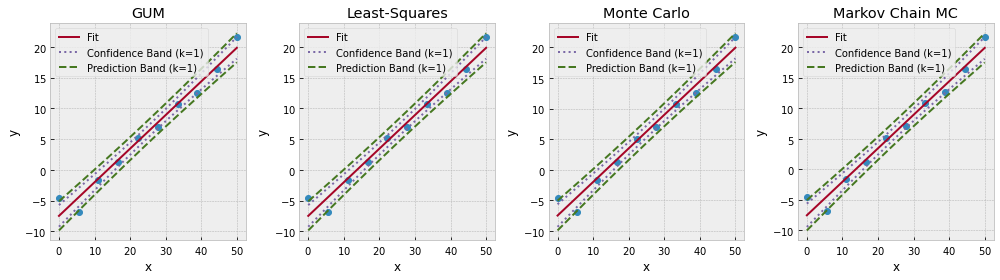

In [3]:
# Generate some data
a, b = -5, .5
uy = 3
x = np.linspace(0,50,num=10)
y = a + b * x + np.random.normal(loc=0, scale=uy, size=len(x))

# Compute the fit
arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(arr)
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

# Non-linear fitting

Common functions for quadratic, cubic, polynomial, and exponential are predefined in the CurveFit class and can be used by passing a string argument ('quad', 'cubic', 'poly', or 'exp') to the CurveFit.

|Method (k=1)              | a         | b         | c        |
|-------------------------|---------|---------|---------|
|Least Squares             | 2.03 ± 0.13 | -0.794 ± 0.099 | 0.196 ± 0.025|
|GUM Approximation         | 2.03 ± 0.13 | -0.794 ± 0.098 | 0.196 ± 0.025|
|Monte Carlo               | 2.03 ± 0.13 | -0.791 ± 0.096 | 0.195 ± 0.025|
|Markov-Chain Monte Carlo  | 2.02 ± 0.13 | -0.785 ± 0.096 | 0.194 ± 0.024|

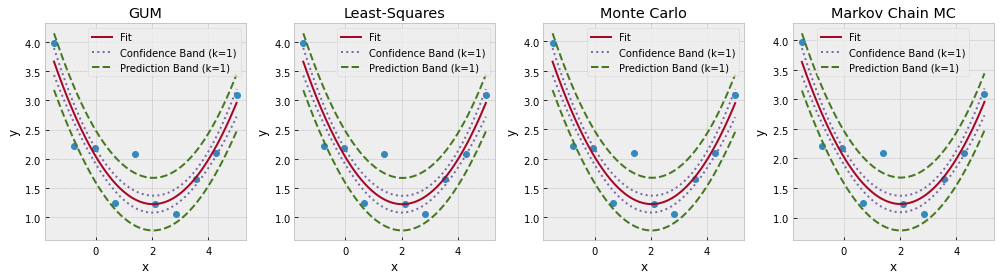

In [4]:
# Generate some quadratic data with noise
a, b, c = 2, -1, 0.25
uy = .3
x = np.linspace(-1.5, 5, num=10)
y = a + b*x + c*x*x + np.random.normal(loc=0, scale=uy, size=len(x))

# Calculate fit and uncertainty
arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func='quad', arr=arr)
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

|Method (k=1)              | a         | b         | c         | d         | e        |
|-------------------------|---------|---------|---------|---------|---------|
|Least Squares             | 0.015 ± 0.22 | -1.08 ± 0.52 | -1.82 ± 0.39 | 0.88 ± 0.57 | 0.65 ± 0.27|
|GUM Approximation         | 0.015 ± 0.22 | -1.08 ± 0.51 | -1.82 ± 0.40 | 0.88 ± 0.56 | 0.65 ± 0.26|
|Monte Carlo               | 0.025 ± 0.22 | -1.06 ± 0.51 | -1.84 ± 0.40 | 0.86 ± 0.56 | 0.67 ± 0.26|
|Markov-Chain Monte Carlo  | 0.018 ± 0.21 | -1.04 ± 0.45 | -1.84 ± 0.39 | 0.85 ± 0.47 | 0.67 ± 0.24|

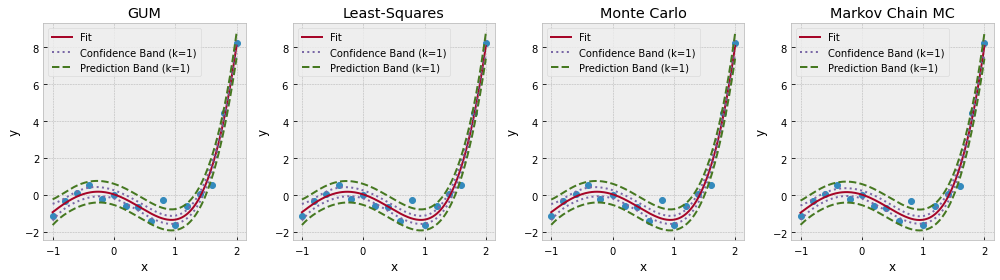

In [5]:
# Polynomial - must also specify the polyorder parameter.
uy = .5
x = np.linspace(-1, 2, num=16)
y = x**4 - 2*x**2 + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(arr, func='poly', polyorder=4)
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

|Method (k=1)              | a         | b         | c        |
|-------------------------|---------|---------|---------|
|Least Squares             | 1.036 ± 0.072 | -1.92 ± 0.31 | 5.004 ± 0.036|
|GUM Approximation         | 1.036 ± 0.078 | -1.92 ± 0.33 | 5.004 ± 0.040|
|Monte Carlo               | 1.041 ± 0.074 | -1.95 ± 0.27 | 5.001 ± 0.035|
|Markov-Chain Monte Carlo  | 1.035 ± 0.072 | -2.00 ± 0.31 | 4.999 ± 0.035|

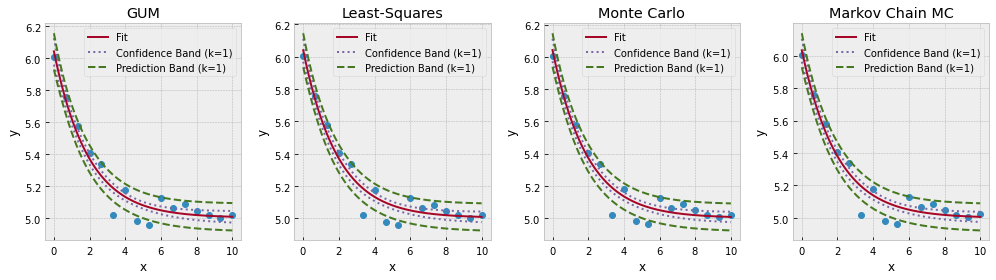

In [6]:
# Exponential
a, b = 2, 5
uy = .08
x = np.linspace(0, 10, num=16)
y = np.exp(-x/a) + b + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func='exp', arr=arr, p0=(1, -2, 5))
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

|Method (k=1)              | b        |
|-------------------------|---------|
|Least Squares             | 1.99 ± 0.14|
|GUM Approximation         | 1.99 ± 0.14|
|Monte Carlo               | 1.99 ± 0.14|
|Markov-Chain Monte Carlo  | 1.99 ± 0.14|

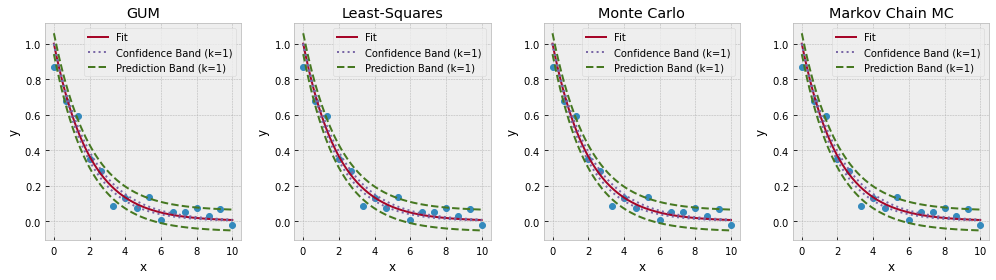

In [7]:
# Exponential, custom-defined as string expression with only one parameter
b = 2
uy = .06
x = np.linspace(0, 10, num=16)
y = np.exp(-x/b) + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func='exp(-x/b)', arr=arr)
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

|Method (k=1)              | a         | b        |
|-------------------------|---------|---------|
|Least Squares             | 145.41 ± 0.33 | 19.68 ± 0.27|
|GUM Approximation         | 145.41 ± 0.33 | 19.68 ± 0.27|
|Monte Carlo               | 145.40 ± 0.33 | 19.66 ± 0.27|
|Markov-Chain Monte Carlo  | 145.40 ± 0.34 | 19.70 ± 0.27|

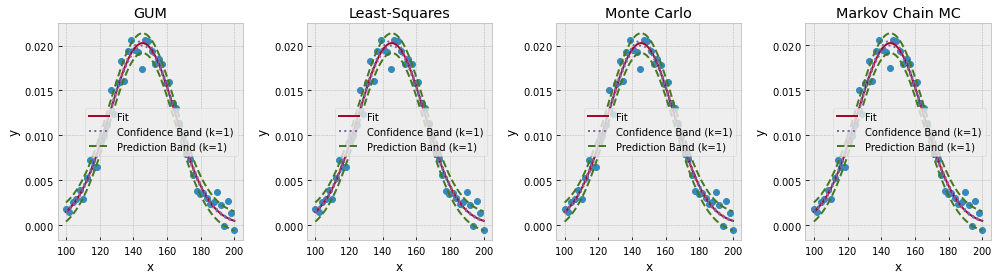

In [8]:
# Normal function - This one needs an initial guess to converge
def func(x, a, b):
    return stats.norm.pdf(x, loc=a, scale=b)

a, b = 145, 20
uy = .001
x = np.linspace(100, 200, 50)
y = func(x, a, b) + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func=func, arr=arr, p0=(a, b))
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

|Method (k=1)              | a         | p         | z        |
|-------------------------|---------|---------|---------|
|Least Squares             | 2.973 ± 0.099 | 0.3930 ± 0.0030 | 1.030 ± 0.071|
|GUM Approximation         | 2.973 ± 0.099 | 0.3930 ± 0.0030 | 1.030 ± 0.071|
|Monte Carlo               | 2.978 ± 0.097 | 0.3931 ± 0.0030 | 1.029 ± 0.070|
|Markov-Chain Monte Carlo  | 2.98 ± 0.100 | 0.3928 ± 0.0030 | 1.029 ± 0.070|

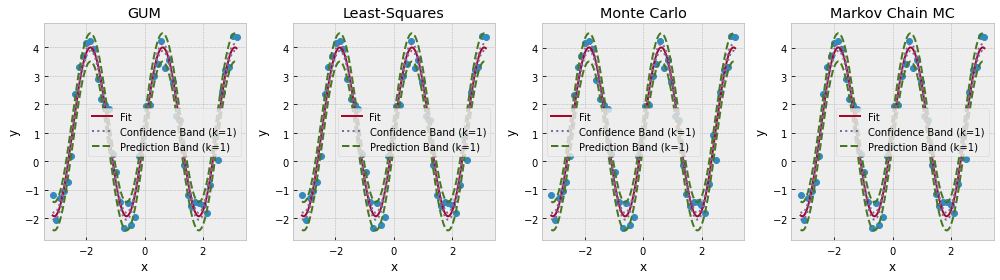

In [9]:
# sine function - Interestingly, MC needs an initial guess, but the others converge without.
def func(x, a, p, z):
    return a * np.sin(x/p) + z

a, p, z = 3, np.pi/8, 1
x = np.linspace(-np.pi, np.pi, 50)
uy = .5
y = func(x, a, p, z) + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func=func, arr=arr, p0=(a, p, z))
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

|Method (k=1)              | gammaG    | gammaL    | center    | base      | area     |
|-------------------------|---------|---------|---------|---------|---------|
|Least Squares             | 2.43 ± 0.62 | 1.47 ± 0.76 | 520.12 ± 0.12 | -0.0018 ± 0.0019 | 1.08 ± 0.10|
|GUM Approximation         | 2.4 ± 3.4 | 1.5 ± 4.5 | 520.12 ± 0.13 | -0.0018 ± 0.0068 | 1.08 ± 0.47|
|Monte Carlo               | 2.36 ± 0.56 | 1.41 ± 0.69 | 520.12 ± 0.12 | -0.0017 ± 0.0018 | 1.075 ± 0.097|
|Markov-Chain Monte Carlo  | 2.50 ± 0.56 | 1.28 ± 0.68 | 520.12 ± 0.13 | -0.0020 ± 0.0019 | 1.093 ± 0.099|

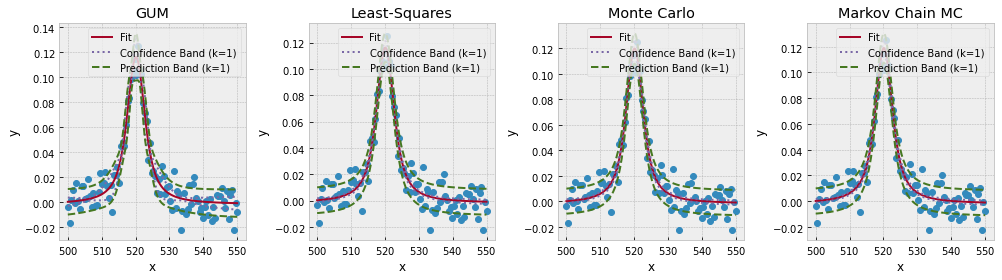

In [10]:
# Voigt function (used in Raman spectroscopy) 
# This is a case where GUM uncertainties don't match other methods.
def func(x, gammaG, gammaL, center, base, area):
    ''' Voigt function, shifted/scaled. '''
    sigma = gammaL / np.sqrt(2 * np.log(2))
    vv = np.real(wofz((x-center + 1j*gammaG)/sigma/np.sqrt(2))) / sigma / np.sqrt(2*np.pi)
    vv = area*vv
    vv += base
    return vv

args = [2, 1.8, 520, 0, 1]
x = np.linspace(500, 550, 100)
uy = .01
y = func(x, *args) + np.random.normal(loc=0, scale=uy, size=len(x))

arr = curvefit.Array(x, y, uy=uy)
f = curvefit.CurveFit(func=func, arr=arr, p0=args)
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=True)
display(out)
plotit(out)

## Uncertainty in X values

The same tests can be repated with uncertainties in the X values. In this case, the curve fit will use orthogonal distance regression, or the York method if the model is linear. Compared to the ux=0 examples above, the uncertainty should be a bit higher for each parameter.

Note the Markov-Chain Monte Carlo method does not currently incorporte uncertainty in X values. Add the `mcmc=True` parameter to the `calculate()` method to see the discrepancy in results.

|Method (k=1)       | b         | a        |
|------------------|---------|---------|
|Least Squares      | 0.551 ± 0.062 | -5.0 ± 1.9|
|GUM Approximation  | 0.545 ± 0.062 | -4.9 ± 1.9|
|Monte Carlo        | 0.538 ± 0.061 | -4.7 ± 2.0|

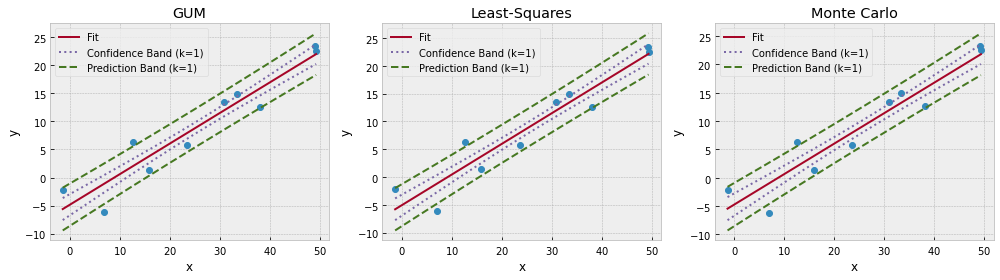

In [11]:
# Generate linear data with uncertainty in x and y
a, b = -5, .5
uy = 3
ux = 2
x = np.linspace(0,50,num=10)
y = a + b * x + np.random.normal(loc=0, scale=uy, size=len(x))
x = x + np.random.normal(loc=0, scale=ux, size=len(x))

# Compute the fit
arr = curvefit.Array(x, y, ux=ux, uy=uy)
f = curvefit.CurveFit(arr, p0=[-5, 0.5])
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=False)
display(out)
plotit(out)

|Method (k=1)       | a         | p         | z        |
|------------------|---------|---------|---------|
|Least Squares      | 3.24 ± 0.17 | 0.3927 ± 0.0074 | 0.96 ± 0.14|
|GUM Approximation  | 2.67 ± 0.19 | 0.3978 ± 0.0088 | 1.13 ± 0.15|
|Monte Carlo        | 2.46 ± 0.18 | 0.3999 ± 0.0084 | 1.10 ± 0.13|

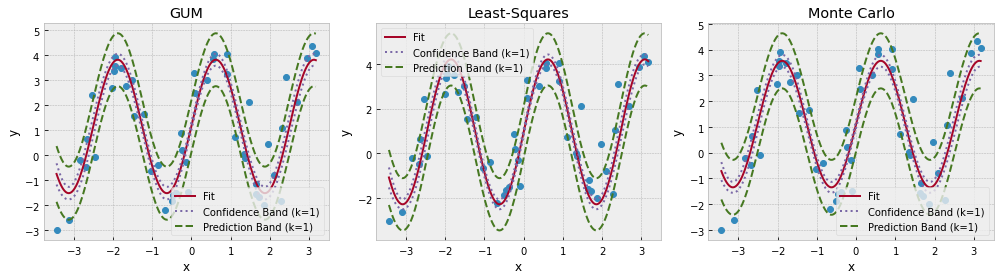

In [12]:
# sine function with uncertainty in x and y
def func(x, a, p, z):
    return a * np.sin(x/p) + z

a, p, z = 3, np.pi/8, 1
x = np.linspace(-np.pi, np.pi, 50)
uy = .5
ux = .2
y = func(x, a, p, z) + np.random.normal(loc=0, scale=uy, size=len(x))
x = x + np.random.normal(loc=0, scale=ux, size=len(x))

arr = curvefit.Array(x, y, ux=ux, uy=uy)
f = curvefit.CurveFit(func=func, arr=arr, p0=(a, p, z))
out = f.calculate(gum=True, mc=True, lsq=True, mcmc=False)
display(out)
plotit(out)